## Importing libraries and PostgreSQL configuration

In [23]:
import pandas as pd
from sqlalchemy import create_engine, text
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with open('C:/Users/Usuario/Workshop_ETL/Workshop_ETL/config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

user = config['POSTGRES_USER']
password = config['POSTGRES_PASSWORD']
host = config['POSTGRES_HOST']
port = config['POSTGRES_PORT']
database = config['POSTGRES_DB']
table =   config['POSTGRES_TABLE']

In [24]:
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

query = f"SELECT * FROM {table};"

df = pd.read_sql(query, engine)
df.head()

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7


In [25]:
df.describe()

,YOE,Code Challenge Score,Technical Interview Score
count,50000.000000,50000.000000,50000.000000
mean,15.286980,4.996400,5.003880
std,8.830652,3.166896,3.165082
min,0.000000,0.000000,0.000000
25%,8.000000,2.000000,2.000000
50%,15.000000,5.000000,5.000000
75%,23.000000,8.000000,8.000000
max,30.000000,10.000000,10.000000


#### Thanks to the method described, we can see that in terms of Year of Experience (YOE) the average is 15 years, but the scores in both exams had an average of 5. This is alarming because it shows that in general the candidates are probably not sufficiently prepared, and in the end this will be reflected in a low level of hired candidates, this is supported by the standard deviation.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   First Name                 50000 non-null  object
 1   Last Name                  50000 non-null  object
 2   Email                      50000 non-null  object
 3   Application Date           50000 non-null  object
 4   Country                    50000 non-null  object
 5   YOE                        50000 non-null  int64 
 6   Seniority                  50000 non-null  object
 7   Technology                 50000 non-null  object
 8   Code Challenge Score       50000 non-null  int64 
 9   Technical Interview Score  50000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


#### According to the information provided, there are no null values, which is good, that means we won't have a problem with the visualization. However, all columns (except YOE, Code Challenge Score, Technical Interview Score, Application Date) have "Object" as data type. This could be a problem for the analysis, because the result can change, so we need to convert them to the correct one.

In [27]:
df['First Name'] = df['First Name'].astype("string")
df['Last Name'] = df['Last Name'].astype("string")
df['Email'] = df['Email'].astype("string")
df['Application Date'] = pd.to_datetime(df['Application Date'], format='%Y/%m/%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   First Name                 50000 non-null  string        
 1   Last Name                  50000 non-null  string        
 2   Email                      50000 non-null  string        
 3   Application Date           50000 non-null  datetime64[ns]
 4   Country                    50000 non-null  object        
 5   YOE                        50000 non-null  int64         
 6   Seniority                  50000 non-null  object        
 7   Technology                 50000 non-null  object        
 8   Code Challenge Score       50000 non-null  int64         
 9   Technical Interview Score  50000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3), string(3)
memory usage: 3.8+ MB


#### Now, the columns have the right data type and the result will be more effective

## Calculate Hiring

#### The "Hired" column is created, which contains the final result whether the candidate was hired or rejected, and then the table in the database is updated with the new information.

In [28]:
def hiring(code_score, technical_score):
    return np.where((code_score >= 7) & (technical_score >= 7), 'Hired', 'Rejected')

df['Hiring'] = hiring(df['Code Challenge Score'], df['Technical Interview Score'])
df.head()

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score,Hiring
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,Rejected
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,Rejected
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,Hired
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,Rejected
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,Hired


In [29]:
postgres_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(postgres_url)
table_name = table

df.to_sql(table_name, engine, if_exists = 'replace', index = False)

print("The data has been inserted correctly into the table, overwriting existing columns if necessary.")

The data has been inserted correctly into the table, overwriting existing columns if necessary.


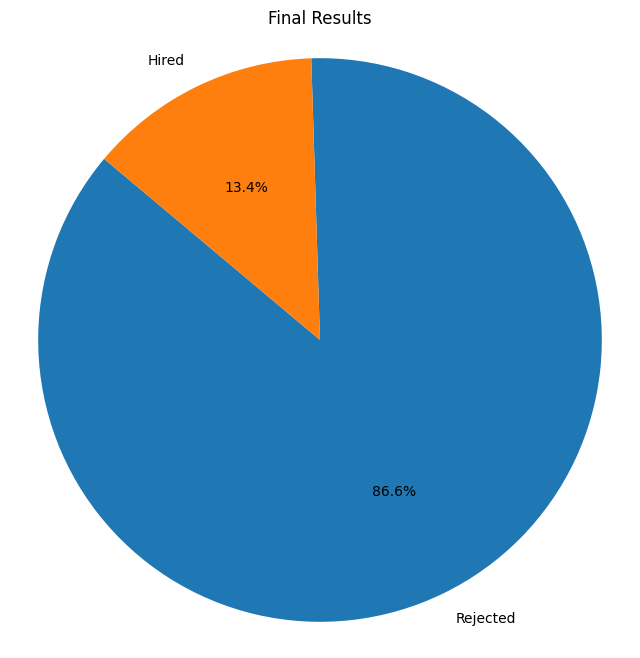

In [30]:
sizes = df['Hiring'].value_counts()
labels = ['Rejected', 'Hired']

plt.figure(figsize = (8, 8))
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 140)
plt.title('Final Results')
plt.axis('equal')
plt.show()


#### As expected the results were very bad, only 13.4% were hired, just looking at the number we can say that it's because the test was very difficult, and this also shows the type of company they were applying for, not just anyone can be there, the candidate must have the required skills for the job, and this test filtered very well the good candidates over the bad ones.

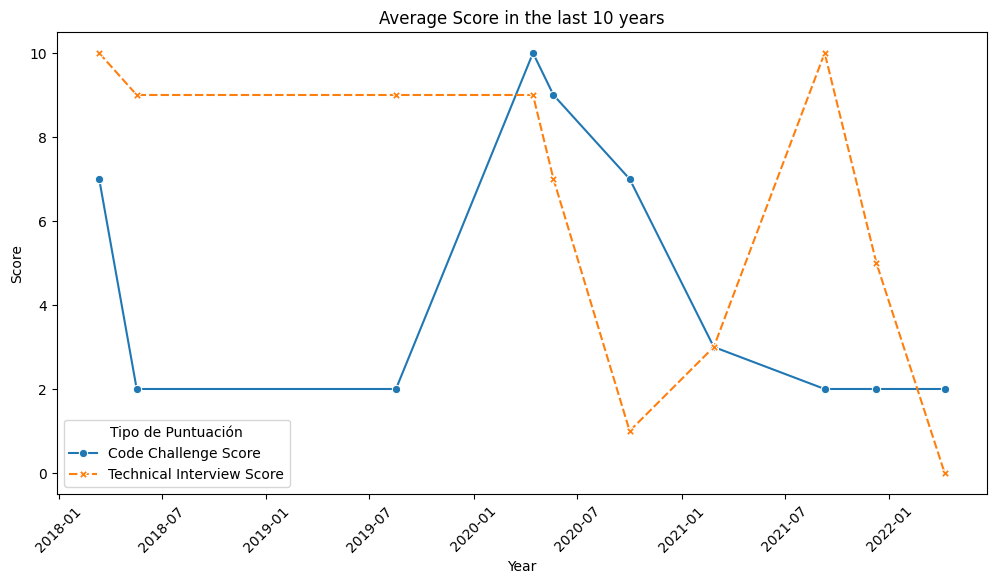

In [31]:
df_top_10 = df.head(10)
df_melted = pd.melt(df_top_10, id_vars=['Application Date'], value_vars=['Technical Interview Score', 'Code Challenge Score'], var_name='Score Type', value_name='Score')
df_avg_scores = df_melted.groupby(['Application Date', 'Score Type'])['Score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_scores, x='Application Date', y='Score', hue='Score Type', style='Score Type', markers=True)
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Average Score in the last 10 years')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Puntuación')
plt.show()

#### Here we can see that the candidates performed better in the technical interview than in the code challenge, we can see that there was a peak, in 2020 there was a period where the performance was almost perfect, it would be correct to think that in that period there was also a peak in hires.

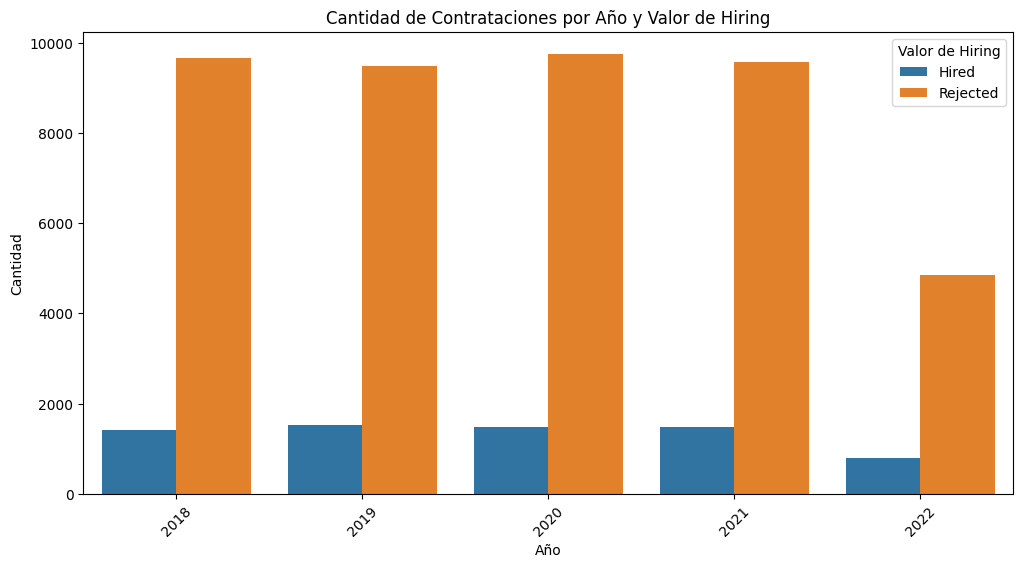

In [32]:
df['Year'] = pd.to_datetime(df['Application Date']).dt.year

# Agrupar los datos por año y por los valores únicos de 'Hiring', y luego contar las ocurrencias
df_yearly_hiring_counts = df.groupby(['Year', 'Hiring']).size().reset_index(name='Count')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=df_yearly_hiring_counts, x='Year', y='Count', hue='Hiring')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Cantidad de Contrataciones por Año y Valor de Hiring')
plt.xticks(rotation=45)
plt.legend(title='Valor de Hiring')
plt.show() 

#### As we can see, the number of candidates hired during 2020 weren't too different to other years as we expected in the last graphic, and we can see that the number of hired ones are significantly small in 2022 as compared to other years, however, this is because the data collected in the dataset goes until 2022, we have to be careful with this kind of things because it may create confusion for the final summary.